In [1]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

Populating the interactive namespace from numpy and matplotlib
TFP Version 0.10.0-rc0
TF  Version 2.2.0


In [0]:
# class NVPLayer(tf.keras.layers.Layer):
class NVPLayer(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_masked = num_masked
        self.shift_and_log_scale_fn_1 = tfb.real_nvp_default_template(
            hidden_layers=[128, 128],
            activation=tf.nn.leaky_relu)
        self.shift_and_log_scale_fn_2 = tfb.real_nvp_default_template(
            hidden_layers=[128, 128],
            activation=tf.nn.leaky_relu)
        self.shift_and_log_scale_fn_3 = tfb.real_nvp_default_template(
            hidden_layers=[128, 128],
            activation=tf.nn.leaky_relu)
        self.shift_and_log_scale_fn_4 = tfb.real_nvp_default_template(
            hidden_layers=[128, 128],
            activation=tf.nn.leaky_relu)
        
        chain = [tfb.RealNVP(num_masked=self.num_masked,
                shift_and_log_scale_fn=self.shift_and_log_scale_fn_1),
                 tfb.Permute([1,0]),
                 tfb.RealNVP(num_masked=self.num_masked,
                shift_and_log_scale_fn=self.shift_and_log_scale_fn_2),
                 tfb.Permute([1,0]),
                 tfb.RealNVP(num_masked=self.num_masked,
                shift_and_log_scale_fn=self.shift_and_log_scale_fn_3),
                 tfb.Permute([1,0]),
                 tfb.RealNVP(num_masked=self.num_masked,
                shift_and_log_scale_fn=self.shift_and_log_scale_fn_4)]

        bij = tfb.Chain(chain)
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_identity_multiplier=1.0),
            bijector = bij
        )

    def call(self, *inputs):
        return self.flow.bijector.forward(*inputs)

    def get_loss(self, *inputs):
        return tf.reduce_mean(nvp.log_prob(*inputs)) # how else to do this?


In [3]:
from sklearn import cluster, datasets, mixture

batch_size = 1024
X = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)

print(X.shape, X.dtype)
model = NVPLayer(output_dim=2, num_masked=1)
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
model.summary()

(1024, 2) float32
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Model: "nvp_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 68,104
Trainable params: 68,104
Non-trainable params: 0
_________________________________________________________________


In [0]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)


@tf.function #Adding the tf.function makes it about 10 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

In [0]:
# Training Step

In [7]:
from time import time
start = time()
for i in range(max_epochs):
    ims = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)
    loss = train_step(ims)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   2.5584822 2.0955283641815186
100   1.2062086 2.6096136569976807
200   1.3903681 2.688115119934082
300   1.3307904 2.656222105026245
400   1.1037066 2.6816930770874023
500   1.719653 2.72782564163208
600   1.07788 2.723607063293457
700   0.92247 2.6438257694244385
800   0.78182924 2.657026529312134
900   0.62745667 2.761458396911621
1000   0.62051827 2.778958559036255
1100   0.48839474 2.6948585510253906
1200   0.4832791 2.6598916053771973
1300   0.413544 2.672874927520752
1400   0.42318484 2.675199031829834
1500   0.43529022 2.651381015777588
1600   0.36944193 2.6812052726745605
1700   0.34759408 2.671696424484253
1800   0.40756655 2.643587589263916
1900   0.37286216 2.629924774169922
2000   0.35321394 2.6304008960723877
2100   0.3685475 2.6035444736480713
2200   0.35833353 2.615960121154785
2300   0.3348218 2.6353349685668945
2400   0.34710616 2.640578031539917
2500   0.33356303 2.628951072692871
2600   0.3416059 2.6173031330108643
2700   0.3593502 2.5998127460479736
2800   0.3812

In [8]:
#model(X)
xc,yc = meshgrid(linspace(-1.5,2.5,128),linspace(-1.,1.5,128))
Z = stack([xc.flatten(), yc.flatten()],axis=1).astype('float32')
print(Z.shape, Z.dtype)

@tf.function
def get_log(X):
    return model.flow.log_prob(X)

S = get_log(Z)

#S = model.flow.log_prob(Z)
print(S.shape, S.dtype)

(16384, 2) float32
(1024, 2) float32
(16384,) <dtype: 'float32'>


(16384,) <class 'numpy.ndarray'> float32


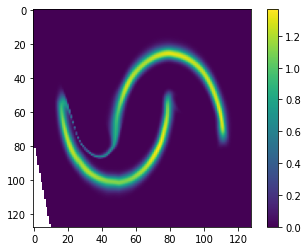

In [9]:
S = S.numpy()
print(S.shape, type(S), S.dtype)
imshow(exp(S.reshape((128,128)))); colorbar()

In [10]:
print(loss.numpy())

0.33156407
